In [1]:
import os
import glob
from nansat import *
from scipy.ndimage.filters import gaussian_filter, median_filter
from matplotlib.colors import LogNorm
from scipy.ndimage.interpolation import rotate
from multiprocessing import Pool
from matplotlib.patches import Polygon

In [2]:
sentinel_data_root = os.path.join('~', 'Documents', 'Work', 'sentinel2a_data')
# Sentinel 2a image data path
ifile = '/home/artemm/Documents/Work/MichiganLake/sentinel2a_data/S2A_OPER_PRD_MSIL1C_PDMC_20160623T012209_R083_V20160622T164039_20160622T164039.SAFE'

sbd_granules = [
    '16TER', '16TFR',
    '16TEQ', '16TFQ'
]

In [3]:
# Granules: 01make_granules.py
# Get list of granules
# What is granules: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types

gdirs = sorted(glob.glob(os.path.join(ifile, 'GRANULE', '*')))

lons = [] # List of longitudes for each granule 
lonVec = [] # ???
lats = [] # List of latitudes for each granule
latVec = [] # ???
labels = [] # List on names for each granule
# Part I: Generation of domain
# For each granule in granules list / gdirs
for gdir in gdirs:
    # Get B01.jp2 image (granule) path 
    # About jp2: https://ru.wikipedia.org/wiki/JPEG_2000
    b01file = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B01.jp2'))[0]
    
    # Get granule image by nansat
    n = Nansat(b01file)
    # Get max/min lat and long of granule 
    lon, lat = n.get_border()
    ## print lon, lat
    lons += list(lon)
    lats += list(lat)
    
    # For what this two rows ??? 
    lonVec.append(lon)
    latVec.append(lat)
    # Add name/label of granule to list
    labels.append(b01file.split('_')[-2][1:])

# Create Domain which is based on max and min lat and long from all (!!!) granules
# 1000 x 1000 is resolution of MODIS-a img ? 
d = Domain(n.vrt.get_projection(), '-lle %f %f %f %f -tr 1000 1000' % (
    min(lons), min(lats), max(lons), max(lats)))

## print(d)

# Create name for export of img which all granules
mapfile = os.path.split(ifile)[1] + '_map.png'
## print(mapfile)
d.write_map(mapfile, resolution='h',
            lonVec=lonVec, latVec=latVec,
            lonBorder=1, latBorder=1,
            dpi=150,
            labels=labels)

# Part II: Reprojection of granules
# Generate 2d array which will have shape like #d annd fill by nan
s2array = np.zeros(d.shape()) + np.nan 
# For each granule in granules list / gdirs
for gdir in gdirs:
    # Get B01.jp2 image (granule) path     
    b01file = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B01.jp2'))[0]
    ## print b01file
    n = Nansat(b01file)
    # Reprojection of granule according #d, 0 is nearest neighbour
    n.reproject(d, eResampleAlg=0)
    # Get data array from nansat obj
    b1 = n[1]
    # All areas in #s2array array will filled by vales from granule
    # As result, after loop we will get one object which contain data from all granules 
    s2array[b1 > 0] = b1[b1 > 0]

# Create nansat obj according #d which contain watter mask
wm = Nansat(domain=d).watermask()[1]
# Why wm == 2 ?? From documentation: Create numpy array with watermask (water=1, land=0)
s2array[wm == 2] = 0

# Create name of file
qlfile = os.path.split(ifile)[1] + '_ql.png'
# Save on disk full generated image: #s2array
plt.imsave(qlfile, s2array, vmin=1050, vmax=1400)

11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:36|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:31:54|30|nansat|_get_mapper|No 

In [4]:
# RGB: 02make_rgb.py
# Only for one granule
granule = '16TFR'

factor = None

gi = 0

# Create path for data in used granule
grndir = ifile + '/GRANULE/*_T%s_N02.04/IMG_DATA/' % granule

# Getting of files with needed bands
# Information about bands: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric
rgb_files = sorted(glob.glob(grndir + '*_B0[2,3,4].jp2'), reverse=True)
rgb_data = []
# For each file in files list #rgb_files
for rgb_file in rgb_files:
    # Open file with Nansat
    n = Nansat(rgb_file)
    if factor is not None:
        n.resize(factor=factor, eResampleAlg=0)
    b1 = n[1]
    rgb_data.append(b1)


mask = ((rgb_data[0] > 0) * (rgb_data[0] < 1200)).astype('uint8')

#wm = n.watermask()[1]
#mask[wm == 2] = 2

f = Figure(rgb_data, mask_array=mask, mask_lut={0:[255,255,255], 2:[128,128,128]})
clim = f.clim_from_histogram(ratio=0.95)
f.process(cmin=clim[0], cmax=clim[1], logarithm=True, gamma=3)
f.save(os.path.split(ifile)[1] + granule + '_rgb.png')

11:32:10|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:32:24|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
11:32:39|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!


In [3]:
# Downscaling: 03downscale.py
def stich(band):
    global gdirs
    # Generate 2d array which will have shape like #d and filled by nan
    bandArray = np.zeros(d.shape()) + np.nan
    for gdir in gdirs:
        bfile = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B%02d.jp2' % band))[0]
        n = Nansat(bfile)
        # Reprojection of data according to domain; eResampleAlg 1 is Bilinear
        n.reproject(d, eResampleAlg=1, addmask=False)
        # Get data array from nansat object 
        bdata = n[1]
        # 
        bandArray[bdata > 0] = bdata[bdata > 0]

    return bandArray

# north sea
gdirs = []
granules = ['16TER', '16TFR', '16TEQ', '16TFQ']

# get directories of relevant granules
for granule in granules:
    gdirs += sorted(glob.glob(os.path.join(ifile, 'GRANULE', '*_T%s_*' % granule)))

# get lon/lat limits
# Lists for accumulation of lon/lat values from each granule
lons = []
lats = []
for gdir in gdirs:
    # Find absolute path to relevant granule
    b0file = glob.glob(os.path.join(gdir, 'IMG_DATA', '*_B01.jp2'))[0]
    # Get granule by nansat 
    n = Nansat(b0file)
    lon, lat = n.get_corners()
    # Add min/max values of long and lat to list
    lons += list(lon)
    lats += list(lat)

# Create domain according to max and min values of lon and lat
d = Domain(n.vrt.get_projection(), '-lle %f %f %f %f -tr 60 60' % (
            min(lons), min(lats), max(lons), max(lats)))

# Create base nansat obj with nan array on a board 
n = Nansat(domain=d, array=np.zeros(d.shape(), np.int8))

# Save created file on a disk. So save a file which contain a domain
n.export(os.path.split(ifile)[1] + '_domain.nc')

# list of requested bands
# Information about bands: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric
bands = range(1, 12)

# Number of threadds
# Documentation: https://docs.python.org/2/library/multiprocessing.html#module-multiprocessing.pool
p = Pool(7)

# For each granule get reprojected array on each band from bands
bData = p.map(stich, bands)
# Transformate map.object to numpy array
bData = np.array(bData)

ofile = os.path.split(ifile)[1] + '.npz'
np.savez_compressed(ofile, bData)

01:31:14|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:14|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:14|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:14|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:15|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:17|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:20|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:22|30|nansat|_get_mapper|No mapper fits, returning GDAL bands!
01:31:22|30|nansat|_get_mapper|No 

In [9]:
hiresfile = os.path.split(ifile)[1] + '.npz'
hires = np.load(hiresfile)
np.lib.npyio.NpzFile?

/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


0
23.0


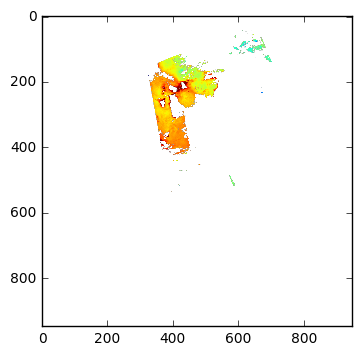

/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


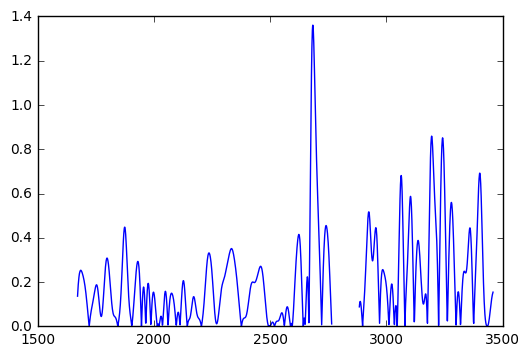

23.1


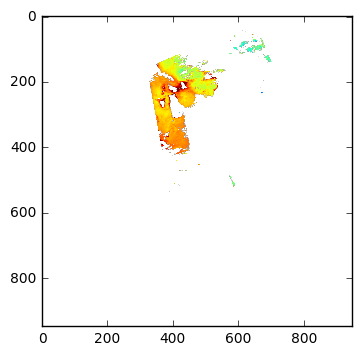

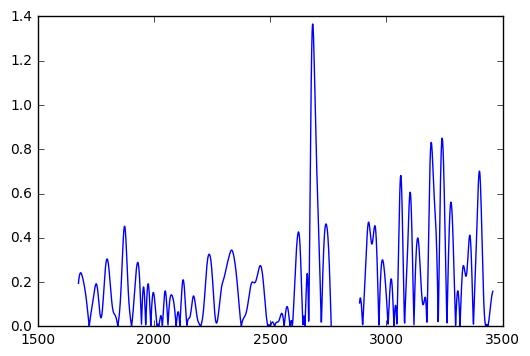

23.2


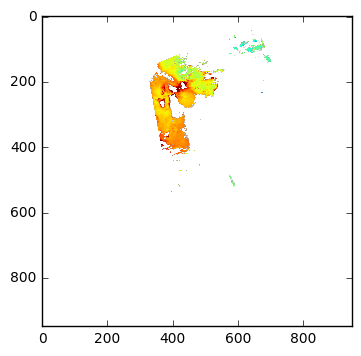

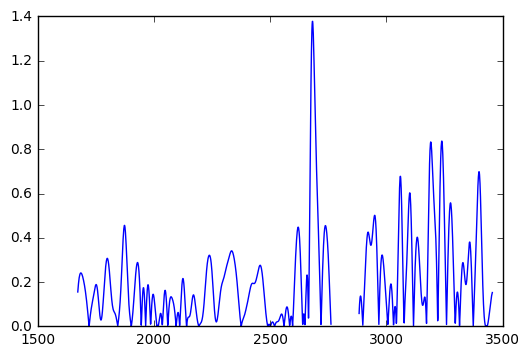

23.3


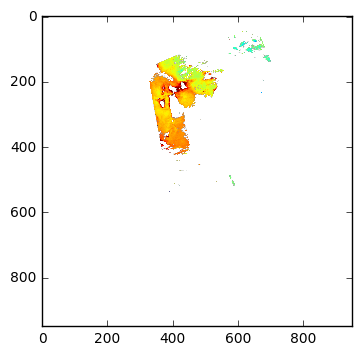

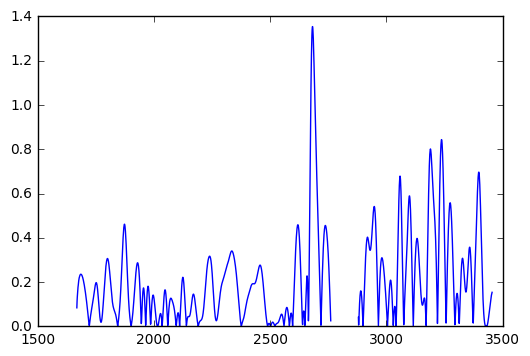

23.4


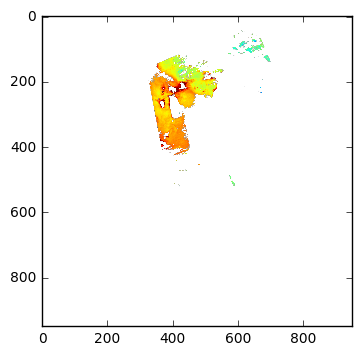

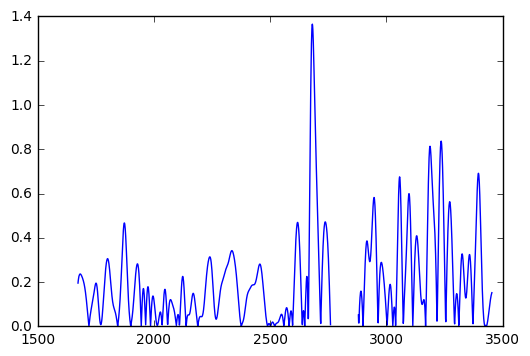

23.5


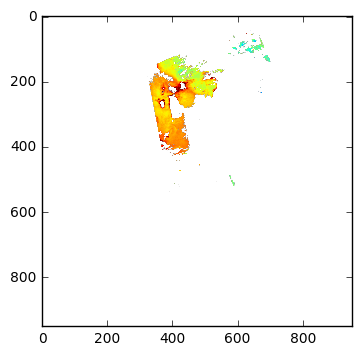

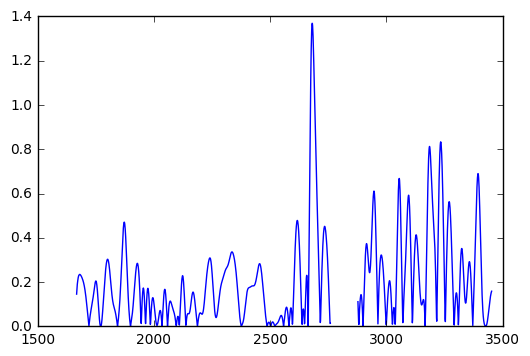

23.6


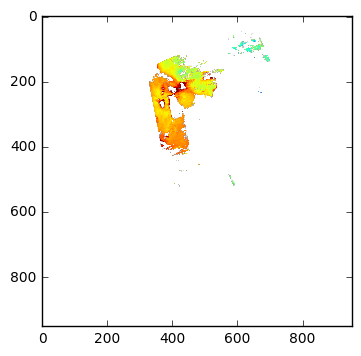

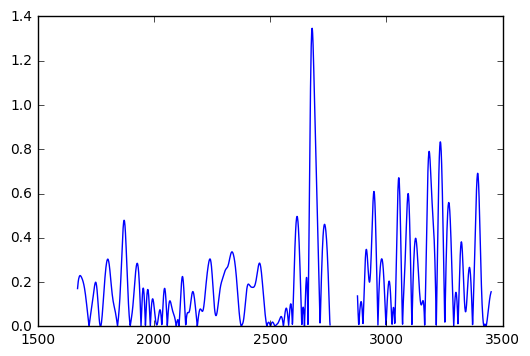

23.7


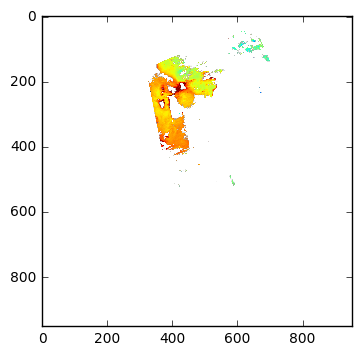

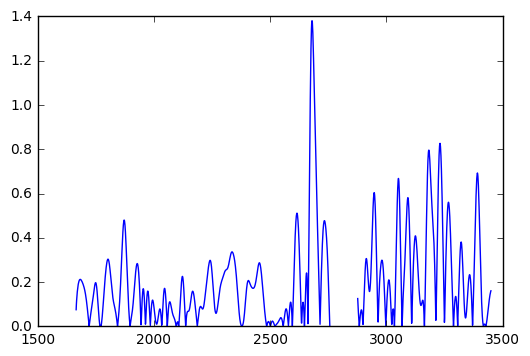

23.8


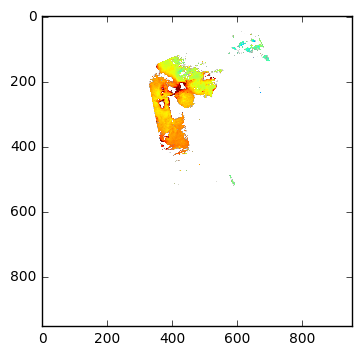

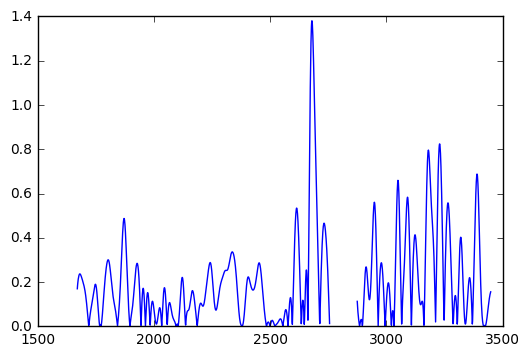

23.9


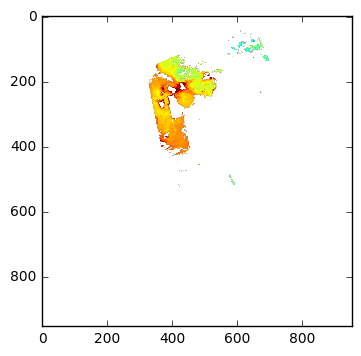

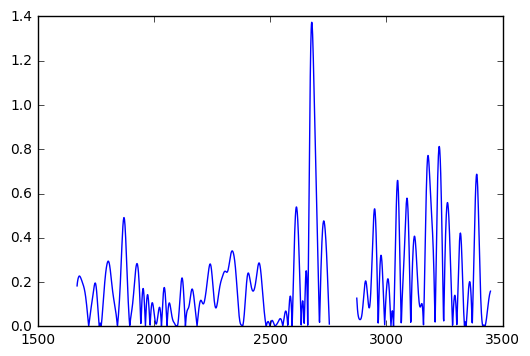

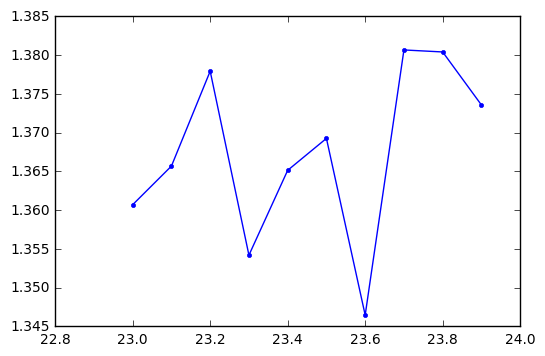

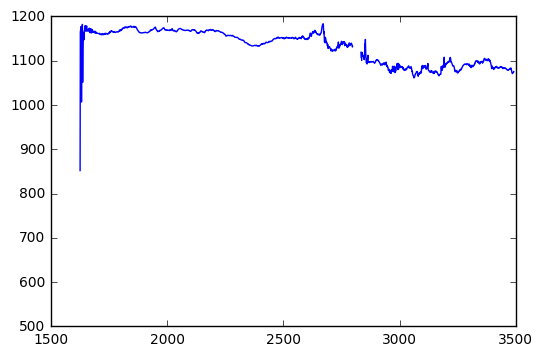

/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers
    pool._maintain_pool()
  File "/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/multiprocessing/pool.py", line 230, in _maintain_pool
    self._repopulate_pool()
  File "/home/artemm/Programs/Miniconda/miniconda2/envs/nansat/lib/python2.7/multiprocessing/pool.p

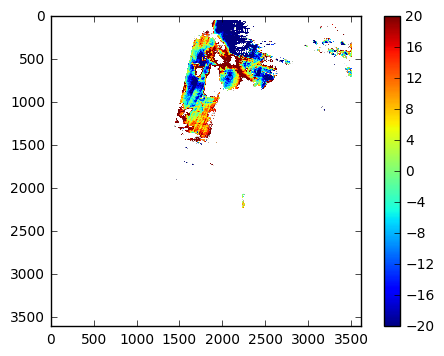

1


MemoryError: 

In [4]:
# Find angle that gives max difference between bands: 04describe.py
    
hiresfile = os.path.split(ifile)[1] + '.npz'
corfile = hiresfile.replace('.npz', '_cor.npz')

mask = np.load(hiresfile)['arr_0'][5] > 200

bands = range(0, 12)

corrected = []
angle = None
for band in bands:
    print band
    # load hi-res
    hires = np.load(hiresfile)['arr_0'][band].astype(np.float64)
    hires[mask] = np.nan

    # find angle
    if angle is None:
        # From where we gets angles
        angles = np.arange(23, 24, 0.1)
        maxdif = []
        for angle in angles:
            print angle
            hr_rot = rotate(hires, angle, order=0, cval=np.nan)
            plt.imshow(hr_rot[::5, ::5], vmin=950, vmax=1250);plt.show()
            # For what we make filtration?
            hr_mean = gaussian_filter(np.nanmean(hr_rot, axis=0), 10)
            maxdif.append(np.nanmax(np.abs(np.diff(hr_mean))))
            plt.plot(np.abs(np.diff(hr_mean)));plt.show()

        plt.plot(angles, maxdif, '.-');plt.show()
        angle = angles[np.argmax(maxdif)]

    hr_rot = rotate(hires, angle, order=0, cval=np.nan)
    hr_mean = np.nanmean(hr_rot, axis=0)
    #plt.imshow(hr_rot, vmin=950, vmax=1250);plt.show()
    plt.plot(hr_mean);plt.show()

    hr_mean_grd = np.repeat(hr_mean[None], hr_rot.shape[0], axis=0)

    hr_mean_grd_rot = rotate(hr_mean_grd, -angle, order=0, cval=np.nan)

    #plt.imshow(hr_rot - hr_mean_grd, vmin=-20, vmax=20);plt.colorbar();plt.show()


    h0, w0 = hires.shape
    aa = np.radians(angle)
    h1 = np.round(w0*np.sin(aa) + h0*np.cos(aa))
    w1 = np.round(h0*np.sin(aa) + w0*np.cos(aa))

    h2 = np.round(w1*np.sin(aa) + h1*np.cos(aa))
    w2 = np.round(h1*np.sin(aa) + w1*np.cos(aa))
    dc = (w2 - w0) / 2.
    dr = (h2 - h0) / 2.

    # Exception of rows of noise from main image
    hires_cln = hires - hr_mean_grd_rot[dr:dr+h0, dc:dc+w0]
    plt.imshow(hires_cln, vmin=-20, vmax=20);plt.colorbar();plt.show()

    corrected.append(hires_cln)

np.savez_compressed(corfile, np.array(corrected))


# make RGB from corrected and non corrected data
#%cpaste
b5 = np.load(hiresfile)['arr_0'][5]
mask = ((b5 > 200) + np.isnan(b5)).astype(np.uint8)

f0 = Figure(np.load(hiresfile)['arr_0'][:3],
            mask_array=mask,
            mask_lut={1:[255,255,255]},
            ratio=0.99)
cmin, cmax = f0.clim_from_histogram()
f0.process(cmin=cmin, cmax=cmax)
f0.save(hiresfile + '_rgb.jpg')


f1 = Figure(np.load(corfile)['arr_0'][:3],
            mask_array=mask,
            mask_lut={1:[255,255,255]},
            ratio=0.97)
cmin, cmax = f1.clim_from_histogram()
f1.process(cmin=cmin, cmax=cmax)
f1.save(corfile + '_rgb.jpg')


In [ ]:
# Create new geolocation for MODIS-a image: 05repro_modis.py
sfile = '/Data/sat/downloads/sentinel2/S2A_OPER_PRD_MSIL1C_PDMC_20160427T192521_R137_V20160427T110623_20160427T110623.SAFE'
mfile = '/Data/sat/downloads/MODIS/NorthSea/A2016118121500.L2_LAC_OC.nc'
# Generate path to domain file 
domainfile = os.path.split(sfile)[1] +  '_domain.nc'
# get domain file by nansat
n2 = Nansat(domainfile)

ofile = os.path.split(mfile)[1] + '_pro.nc'
# GCP_COUNT is frequncy of rows used for gettin coordinates array ? 
# Get MODIS-a image by nansat
n = Nansat(mfile, GCP_COUNT=40)
# Remove geolocation
n.vrt.remove_geolocationArray()
n.vrt.tps = True
n.reproject_GCPs()
print n.time_coverage_start

# add index of pixels
index = np.arange(0,
    n.shape()[0] * n.shape()[1]).reshape(n.shape()).astype('int32')
n.add_band(index, parameters={'name': 'index'})

n.reproject(n2, addmask=False)
#bands = ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'angstrom', 'aot_869', 'chlor_a']
#bands = ['Rrs_667', 'Rrs_555', 'Rrs_488', 'Rrs_443', 'Rrs_412']
bands = ['index', 'Rrs_667', 'Rrs_555', 'Rrs_488']

nexp = Nansat(domain=n2)
for band in bands:
    print band,
    bandArray = n[band]
    print bandArray.dtype
    nexp.add_band(bandArray, parameters={'name': band})

nexp.export(ofile)

In [10]:
np.diff?